In [1]:
##setup for loading data, you can skip this cell
import pandas as pd
from pathlib import Path

DATA_DIR = Path.cwd() / "data"
DATA_DIR.mkdir(exist_ok=True)


# 1968-2016 General (fivethirtyeight)
polls = pd.read_csv(
    'https://raw.githubusercontent.com/fivethirtyeight/data/master/polls/pres_pollaverages_1968-2016.csv',
    parse_dates=['modeldate']
)

# 2020 General (fivethirtyeight)
polls_2 = pd.read_csv(
    'https://raw.githubusercontent.com/fivethirtyeight/data/refs/heads/master/polls/2024-averages/presidential_general_averages_2024-09-12_uncorrected.csv',
    parse_dates=['date']
)



# Manually backfill National data after 2024-09-12
manual_rows = []


def add_range(start, end, harris_val, trump_val):
    # Build two rows per day: Harris and Trump
    for d in pd.date_range(start=start, end=end, freq='D'):
        manual_rows.append({
            'cycle': 2024,
            'state': 'National',
            'date': d,
            'candidate': 'Kamala D. Harris',
            'pct_trend_adjusted': harris_val,
        })
        manual_rows.append({
            'cycle': 2024,
            'state': 'National',
            'date': d,
            'candidate': 'Donald Trump',
            'pct_trend_adjusted': trump_val,
        })


add_range('2024-09-13', '2024-09-13', 49, 45)
add_range('2024-09-14', '2024-09-14', 49, 45)
add_range('2024-09-15', '2024-09-15', 49, 46)
add_range('2024-09-16', '2024-10-03', 49, 46)
add_range('2024-10-04', '2024-10-04', 49, 47)
add_range('2024-10-05', '2024-10-07', 50, 47)
add_range('2024-10-08', '2024-11-04', 49, 47)

manual_df = pd.DataFrame(manual_rows)
polls_2 = pd.concat([polls_2, manual_df], ignore_index=True)


#2024

# National Average
National = polls[polls['state'] == 'National'].copy()
National2 = polls_2[polls_2['state'] == 'National'].copy()

National2['pct_trend_adjusted'] = National2['pct_trend_adjusted'].fillna(
    National2['pct_estimate']
)


data1 = National[['cycle','state','modeldate','candidate_name','pct_trend_adjusted']]
data2 = National2[['cycle','state','date','candidate','pct_trend_adjusted']]


# align column names
data2.columns=['cycle','state','modeldate','candidate_name','pct_trend_adjusted']
data2.sort_values('modeldate', ascending=True, inplace=True)

# main data for trading
polldata = pd.concat([data2,data1],axis=0)

# Winner mapping for labeling (adjust names to match dataset)
winners = {
    1968: "Richard M. Nixon",
    1972: "Richard M. Nixon",
    1976: "Jimmy Carter",
    1980: "Ronald Reagan",
    1984: "Ronald Reagan",
    1988: "George H. W. Bush",
    1992: "Bill Clinton",
    1996: "Bill Clinton",
    2000: "George W. Bush",
    2004: "George W. Bush",
    2008: "Barack Obama",
    2012: "Barack Obama",
    2016: "Donald Trump",
    2020: "Joseph R. Biden Jr.",
    2024: "Donald Trump",
}

polldata["winner"] = polldata["cycle"].map(winners)

polldata.to_csv(DATA_DIR / 'polldata.csv', index=False)


/var/folders/cw/gsf83db94mbbq40jtb_6bm240000gn/T/ipykernel_33712/301773808.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.sort_values('modeldate', ascending=True, inplace=True)


In [2]:
polldata[polldata['cycle']==2024]

,cycle,state,modeldate,candidate_name,pct_trend_adjusted,winner
24802,2024,National,2024-03-01,Biden,39.72335,Donald Trump
24801,2024,National,2024-03-01,Trump,41.73985,Donald Trump
24800,2024,National,2024-03-01,Kennedy,10.34620,Donald Trump
24799,2024,National,2024-03-02,Biden,39.55785,Donald Trump
24798,2024,National,2024-03-02,Trump,41.98310,Donald Trump
...,...,...,...,...,...,...
27202,2024,National,2024-11-02,Donald Trump,47.00000,Donald Trump
27203,2024,National,2024-11-03,Kamala D. Harris,49.00000,Donald Trump
27204,2024,National,2024-11-03,Donald Trump,47.00000,Donald Trump
27205,2024,National,2024-11-04,Kamala D. Harris,49.00000,Donald Trump


In [3]:
import pandas as pd

df = pd.read_csv("data/polldata.csv")
df["modeldate"] = pd.to_datetime(df["modeldate"])

polls_by_cycle = {}

for cyc, grp in df.groupby("cycle"):
    pivot = (
        grp.pivot_table(
            index="modeldate",
            columns="candidate_name",
            values="pct_trend_adjusted",
            aggfunc="mean"
        )
        .sort_index()
    )

    # Drop candidates that do not have a value on the last date
    last_row = pivot.iloc[-1]
    pivot = pivot.loc[:, ~last_row.isna()]

    # If 3+ candidates remain, keep the top 2 by last-date value (drop lowest third-party)
    if pivot.shape[1] > 2:
        keep_cols = last_row.dropna().sort_values(ascending=False).index[:2]
        pivot = pivot[keep_cols]

    cols = list(pivot.columns)
    if len(cols) >= 2:
        diff = (pivot[cols[0]] - pivot[cols[1]]).abs()
        pivot.insert(2, "margin", diff)

    polls_by_cycle[f"{cyc}poll"] = pivot

polls_by_cycle['1968poll']


candidate_name,Richard M. Nixon,"Hubert Humphrey, Jr.",margin
modeldate,,,
1968-04-09,47.40974,35.15829,12.25145
1968-04-10,47.40974,35.15829,12.25145
1968-04-11,47.40974,35.15829,12.25145
1968-04-12,47.40974,35.15829,12.25145
1968-04-13,47.40974,35.15829,12.25145
...,...,...,...
1968-11-01,48.15137,33.30362,14.84775
1968-11-02,47.83623,40.46579,7.37044
1968-11-03,47.83623,40.46579,7.37044


In [4]:
from pathlib import Path

# Save polls_by_cycle to CSV for reuse in other notebooks
out_dir = Path("data/polls_by_cycle")
out_dir.mkdir(parents=True, exist_ok=True)
for key, df in polls_by_cycle.items():
    out_path = out_dir / f"{key}.csv"
    df.to_csv(out_path, index=True)

print(f"Saved {len(polls_by_cycle)} files to {out_dir}")


Saved 15 files to data/polls_by_cycle


(<Figure size 1000x500 with 2 Axes>,
 (<Axes: title={'center': '2024poll polling'}, xlabel='modeldate', ylabel='pct_trend_adjusted'>,
  <Axes: xlabel='modeldate', ylabel='margin'>))

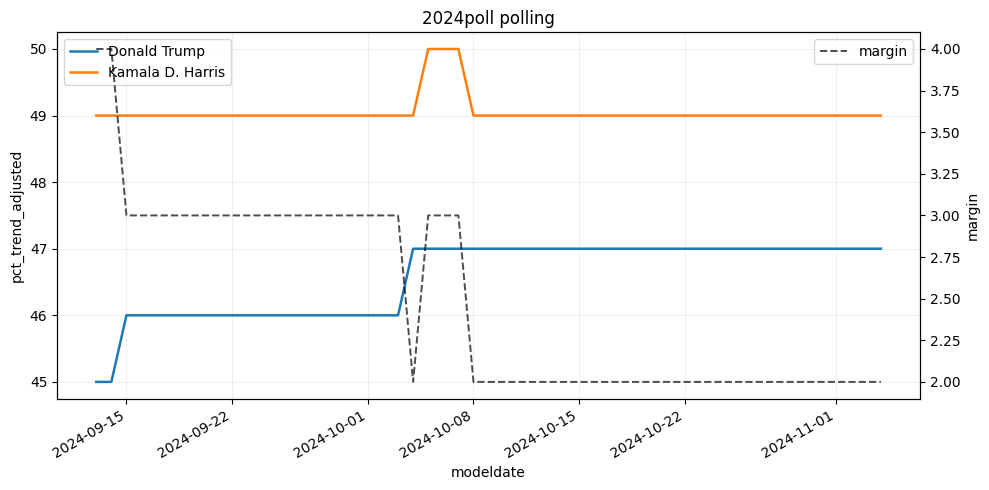

In [5]:
#Graph
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_cycle(cycle_key):
    df = polls_by_cycle[cycle_key]
    candidate_cols = [c for c in df.columns if c != "margin"]

    fig, ax1 = plt.subplots(figsize=(10, 5))
    df[candidate_cols].plot(ax=ax1, lw=1.8)
    ax1.set_ylabel("pct_trend_adjusted")
    ax1.grid(True, alpha=0.2)

    if "margin" in df.columns:
        ax2 = ax1.twinx()  # right axis
        df["margin"].plot(ax=ax2, style="k--", lw=1.4, alpha=0.7, label="margin")
        ax2.set_ylabel("margin")
        ax2.legend(loc="upper right")

    ax1.set_title(f"{cycle_key} polling")
    ax1.legend(loc="upper left")
    plt.tight_layout()
    return fig, (ax1, ax2 if 'ax2' in locals() else None)

plot_cycle("2024poll")



In [6]:

import statsmodels.api as sm

# winner mapping
winners = {
    1968: "Richard M. Nixon",
    1972: "Richard M. Nixon",
    1976: "Jimmy Carter",
    1980: "Ronald Reagan",
    1984: "Ronald Reagan",
    1988: "George H. W. Bush",
    1992: "Bill Clinton",
    1996: "Bill Clinton",
    2000: "George W. Bush",
    2004: "George W. Bush",
    2008: "Barack Obama",
    2012: "Barack Obama",
    2016: "Donald Trump",
    2020: "Joseph R. Biden Jr.",
    2024: "Donald Trump",
}

records = []
for name, pivot in polls_by_cycle.items():
    cyc = int(name[:4])
    winner = winners.get(cyc)
    if winner is None:
        continue

    candidates = [c for c in pivot.columns if c != "margin"]
    if len(candidates) < 2:
        continue

    last_day = pivot.index.max()

    def window_stats(days: int):
        window = pivot.loc[last_day - pd.Timedelta(days=days-1): last_day, candidates]
        avg = window.mean()
        leader = avg.idxmax()
        runner = avg.sort_values(ascending=False).index[1]
        margin = avg[leader] - avg[runner]
        return leader, margin, abs(margin)

    l1, m1, m1_abs = window_stats(1)
    l5, m5, m5_abs = window_stats(5)
    l10, m10, m10_abs = window_stats(10)

    records.append({
        "cycle": cyc,
        "leader_last1": l1,
        "leader_avg5": l5,
        "leader_avg10": l10,
        "margin_last1_abs": m1_abs,
        "margin_avg5_abs": m5_abs,
        "margin_avg10_abs": m10_abs,
        "mismatch_last1": int(l1 != winner),
        "mismatch_avg5": int(l5 != winner),
        "mismatch_avg10": int(l10 != winner),
    })

feature_df = pd.DataFrame(records).set_index("cycle").sort_index()

In [7]:
X1 = sm.add_constant(feature_df[["margin_last1_abs"]]) 
y1 = feature_df["mismatch_last1"]

logit_1 = sm.Logit(y1, X1).fit(disp=False)
probit_1 = sm.Probit(y1, X1).fit(disp=False)

print("\nLogit summary:\n", logit_1.summary())
print("\nProbit summary:\n", probit_1.summary())



Logit summary:
                            Logit Regression Results                           
Dep. Variable:         mismatch_last1   No. Observations:                   15
Model:                          Logit   Df Residuals:                       13
Method:                           MLE   Df Model:                            1
Date:                Sat, 10 Jan 2026   Pseudo R-squ.:                 0.02374
Time:                        00:03:04   Log-Likelihood:                -7.3278
converged:                       True   LL-Null:                       -7.5060
Covariance Type:            nonrobust   LLR p-value:                    0.5505
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.9511      0.955     -0.996      0.319      -2.822       0.920
margin_last1_abs    -0.0672      0.122     -0.552      0.581      -0.306       0.171

Probit sum

In [8]:
X5 = sm.add_constant(feature_df[["margin_avg5_abs"]]) 
y5 = feature_df["mismatch_avg5"]

logit_5 = sm.Logit(y5, X5).fit(disp=False)
probit_5 = sm.Probit(y5, X5).fit(disp=False)

print("\nLogit summary:\n", logit_5.summary())
print("\nProbit summary:\n", probit_5.summary())


Logit summary:
                            Logit Regression Results                           
Dep. Variable:          mismatch_avg5   No. Observations:                   15
Model:                          Logit   Df Residuals:                       13
Method:                           MLE   Df Model:                            1
Date:                Sat, 10 Jan 2026   Pseudo R-squ.:                 0.02577
Time:                        00:03:04   Log-Likelihood:                -7.3126
converged:                       True   LL-Null:                       -7.5060
Covariance Type:            nonrobust   LLR p-value:                    0.5339
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.9313      0.954     -0.976      0.329      -2.802       0.939
margin_avg5_abs    -0.0687      0.119     -0.575      0.565      -0.303       0.165

Probit summary

In [9]:
X10 = sm.add_constant(feature_df[["margin_avg10_abs"]]) 
y10 = feature_df["mismatch_avg10"]

logit_10 = sm.Logit(y10, X10).fit(disp=False)
probit_10 = sm.Probit(y10, X10).fit(disp=False)

print("\nLogit summary:\n", logit_10.summary())
print("\nProbit summary:\n", probit_10.summary())


Logit summary:
                            Logit Regression Results                           
Dep. Variable:         mismatch_avg10   No. Observations:                   15
Model:                          Logit   Df Residuals:                       13
Method:                           MLE   Df Model:                            1
Date:                Sat, 10 Jan 2026   Pseudo R-squ.:                  0.1036
Time:                        00:03:04   Log-Likelihood:                -7.7976
converged:                       True   LL-Null:                       -8.6987
Covariance Type:            nonrobust   LLR p-value:                    0.1794
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0658      0.909     -0.072      0.942      -1.848       1.716
margin_avg10_abs    -0.1468      0.129     -1.136      0.256      -0.400       0.106

Probit sum

In [10]:
##summary statistics

print("mean of last poll margin : ",X1.mean()["margin_last1_abs"])
print("mean of the number of flipped results from the last poll : ", y1.mean())
print("sum of the number of flipped results from the last poll : ",sum(y1))

print("mean of 5-day average margin : ",X5.mean()["margin_avg5_abs"])
print("mean of the number of flipped results from the 5-day average : ", y5.mean())
print("sum of the number of flipped results from the 5-day average : ",sum(y5))

print("mean of 10-day average margin : ",X10.mean()["margin_avg10_abs"])
print("mean of the number of flipped results from the 10-day average : ", y10.mean())
print("sum of the number of flipped results from the 10-day average : ",sum(y10))

mean of last poll margin :  7.299063733333335
mean of the number of flipped results from the last poll :  0.2
sum of the number of flipped results from the last poll :  3
mean of 5-day average margin :  7.4951438800000005
mean of the number of flipped results from the 5-day average :  0.2
sum of the number of flipped results from the 5-day average :  3
mean of 10-day average margin :  7.970824713333338
mean of the number of flipped results from the 10-day average :  0.26666666666666666
sum of the number of flipped results from the 10-day average :  4


In [11]:
import numpy as np
from scipy.stats import norm
from scipy.special import expit
from scipy import optimize

alpha_1_logit = logit_1.params['const']         
beta_1_logit = logit_1.params['margin_last1_abs']  
alpha_5_logit = logit_5.params['const']         
beta_5_logit = logit_5.params['margin_avg5_abs']  
alpha_10_logit = logit_10.params['const']         
beta_10_logit = logit_10.params['margin_avg10_abs']  

alpha_1_probit = probit_1.params['const']         
beta_1_probit = probit_1.params['margin_last1_abs']  
alpha_5_probit = probit_5.params['const']         
beta_5_probit = probit_5.params['margin_avg5_abs']  
alpha_10_probit = probit_10.params['const']         
beta_10_probit = probit_10.params['margin_avg10_abs']  



p_target = 0.266666
z_logit = np.log(p_target / (1 - p_target))  
z_probit = norm.ppf(p_target)                

logit_params = [
    ("logit_1", alpha_1_logit, beta_1_logit),
    ("logit_5", alpha_5_logit, beta_5_logit),
    ("logit_10", alpha_10_logit, beta_10_logit),
]
probit_params = [
    ("probit_1", alpha_1_probit, beta_1_probit),
    ("probit_5", alpha_5_probit, beta_5_probit),
    ("probit_10", alpha_10_probit, beta_10_probit),
]

logit_x = {name: (z_logit - alpha) / beta
                 for name, alpha, beta in logit_params}
probit_x = {name: (z_probit - alpha) / beta
                  for name, alpha, beta in probit_params}

logit_x, probit_x



({'logit_1': np.float64(0.9003155136565919),
  'logit_5': np.float64(1.1697849848199493),
  'logit_10': np.float64(6.444615628171092)},
 {'probit_1': np.float64(1.1200147925535537),
  'probit_5': np.float64(1.3946449918416701),
  'probit_10': np.float64(6.6440990154764314)})